## Part 2

In [84]:
from google.colab import files
files=files.upload()

Saving heart_assignment2.csv to heart_assignment2 (1).csv


In [85]:
!pip install 'aif360[all]'

In [86]:
# Make Necessary import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector
from aif360.algorithms.preprocessing.lfr import LFR
from aif360.datasets import StandardDataset

from sklearn.metrics import classification_report        
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from IPython.display import Markdown, display
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from aif360.algorithms.preprocessing.reweighing import Reweighing

In [87]:
#Read the data 
heart_data_df = pd.read_csv('heart_assignment2.csv')

In [89]:
#Get the data
heart_data_df.head()

,Age,Sex,Race,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,Asian,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,Other,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,Other,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,White,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,Other,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [90]:
#Get the shape
print(heart_data_df.shape)

(918, 13)


In [91]:
#pre processing the data

le = LabelEncoder()
heart_data_encoded = heart_data_df
# Columns to encode are:
categorical = ['Sex','Race','ChestPainType','RestingECG','ExerciseAngina','ST_Slope'] 
# Label encoding
heart_data_encoded[categorical] = heart_data_df[categorical].apply(le.fit_transform)                 
heart_data_encoded

,Age,Sex,Race,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,0,1,140,289,0,1,172,0,0.0,2,0
1,49,0,3,2,160,180,0,1,156,0,1.0,1,1
2,37,1,3,1,130,283,0,2,98,0,0.0,2,0
3,48,0,4,0,138,214,0,1,108,1,1.5,1,1
4,54,1,3,2,150,195,0,1,122,0,0.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,1,1,3,110,264,0,1,132,0,1.2,1,1
914,68,1,2,0,144,193,1,1,141,0,3.4,1,1
915,57,1,4,0,130,131,0,1,115,1,1.2,1,1
916,57,0,3,1,130,236,0,0,174,0,0.0,1,1


In [92]:
heart_data_encoded.columns

Index(['Age', 'Sex', 'Race', 'ChestPainType', 'RestingBP', 'Cholesterol',
       'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak',
       'ST_Slope', 'HeartDisease'],
      dtype='object')

In [94]:
# Protected attribute
# Substitute the protected_attribute_used variable of Age, Race and Sex with 0, 1 or 2
protected_attribute = 0
if protected_attribute == 0:
  heart_data_orig_aif = StandardDataset(heart_data_encoded,
                              label_name = "HeartDisease", # Name of the column with labels
                              favorable_classes = [0],   # 0 = Good, 1 = Bad                      
                              protected_attribute_names = ["Age"],   # Name of the column with categorical attributes        
                              privileged_classes = [lambda x: x <= 38])   # here we specify the privileged classes for the age attribute (less than or equal to 38)
  privileged_groups = [{"Age": 1}]                                               
  unprivileged_groups = [{"Age": 0}]
elif protected_attribute == 1:
  heart_data_orig_aif = StandardDataset(heart_data_encoded,
                              label_name = "HeartDisease", # Name of the column with labels
                              favorable_classes = [0],   # 0 = Good, 1 = Bad                      
                              protected_attribute_names = ["Race"],   # Name of the column with categorical attributes        
                              privileged_classes = [[4]])   #set white race to privilege class
  privileged_groups = [{"Race": 1}]                                               
  unprivileged_groups = [{"Race": 0}]
else:
  heart_data_orig_aif = StandardDataset(heart_data_encoded,
                              label_name = "HeartDisease", # Name of the column with labels
                              favorable_classes = [0],   # 0 = Good, 1 = Bad                      
                              protected_attribute_names = ["Sex"],   # Name of the column with categorical attributes        
                              privileged_classes = [[1]])   #set Male to privilige Class
  privileged_groups = [{"Sex": 1}]                                               
  unprivileged_groups = [{"Sex": 0}]


In [95]:
#Get the dataset and split into train and test
dataset_orig_train, dataset_orig_vt = heart_data_orig_aif.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = heart_data_orig_aif.split([0.5], shuffle=True)

In [97]:
#Clean up and print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(642, 12)


#### Favorable and unfavorable labels

0.0 1.0


#### Protected attribute names

['Age']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['Age', 'Sex', 'Race', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope']


## Q4 Calculate three different fairness metrics.

In [98]:
# calculate three different fairness metrics. Calculate these metrics for different groups based on the groups you identified as privileged and unprivileged in step 2.
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)



In [99]:
# # 1. Statistical parity Difference 
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())
display(Markdown("#### Original test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.235908


#### Original test dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.298009


In [100]:
# 2. Disparate Impact
display(Markdown("#### Original training dataset"))
print("Disparate Impact outcomes between unprivileged and privileged groups = %f" % metric_orig_train.disparate_impact())
display(Markdown("#### Original test dataset"))
print("Disparate Impact outcomes between unprivileged and privileged groups = %f" % metric_orig_test.disparate_impact())

#### Original training dataset

Disparate Impact outcomes between unprivileged and privileged groups = 0.641770


#### Original test dataset

Disparate Impact outcomes between unprivileged and privileged groups = 0.602654


In [101]:
# 3. Smoothed Empirical Differential Fairness
display(Markdown("#### Original training dataset"))
print("Smoothed Empirical Differential Fairness outcomes between unprivileged and privileged groups = %f" % metric_orig_train.smoothed_empirical_differential_fairness())
display(Markdown("#### Original test dataset"))
print("Smoothed Empirical Differential Fairness outcomes between unprivileged and privileged groups = %f" % metric_orig_test.smoothed_empirical_differential_fairness())

#### Original training dataset

Smoothed Empirical Differential Fairness outcomes between unprivileged and privileged groups = 0.514028


#### Original test dataset

Smoothed Empirical Differential Fairness outcomes between unprivileged and privileged groups = 0.754774


In [102]:
# Now Investigate fairness with a simple classifier
# Training a classifier and investigating the fairness metrics based on the predicted and true values. This will be done using the ClassificationMetric class.
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset_orig_train.instance_weights}

lr_orig= model.fit(dataset_orig_train.features, dataset_orig_train.labels.ravel(), **fit_params)



In [103]:
y_test=model.predict(dataset_orig_test.features)
dataset_pred= dataset_orig_test.copy()
dataset_pred.labels=y_test

metric = ClassificationMetric(
                dataset_orig_test, dataset_pred,
                unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

print("Difference in mean between unprivileged and privileged groups  = %f" % metric.mean_difference())
print("Disparate Impact outcomes between unprivileged and privileged groups = %f" % metric.disparate_impact())
print("Smoothed Empirical Differential Fairness outcomes between unprivileged and privileged groups = %f" % metric.smoothed_empirical_differential_fairness())



Difference in mean between unprivileged and privileged groups  = -0.434719
Disparate Impact outcomes between unprivileged and privileged groups = 0.503178
Smoothed Empirical Differential Fairness outcomes between unprivileged and privileged groups = 0.754774


## Question 7 using AIF-360, implement one pre-processing mitigation technique covered in class.

In [104]:
# Metrics function
from collections import OrderedDict
from aif360.metrics import ClassificationMetric

def compute_metrics(dataset_true, dataset_pred, 
                    unprivileged_groups, privileged_groups,
                    disp = True):
    """ Compute the key metrics """
    classified_metric_pred = ClassificationMetric(dataset_true,
                                                 dataset_pred, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metrics = OrderedDict()
    metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
                                             classified_metric_pred.true_negative_rate())
    metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
    metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
    metrics["Theil index"] = classified_metric_pred.theil_index()
    
    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))
    
    return metrics

In [105]:
# Step 1 Train with and transform the original data
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(dataset_orig_train)
dataset_transf_train = RW.transform(dataset_orig_train)

In [106]:
# Step 2 Metric with transformed data
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.000000


In [107]:
# Step 3 Train classifier with original data
# Logistic regression classifier and predictions
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()
w_train = dataset_orig_train.instance_weights.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train, 
         sample_weight=dataset_orig_train.instance_weights)
y_train_pred = lmod.predict(X_train)

# positive class index
pos_ind = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy()
dataset_orig_train_pred.labels = y_train_pred

In [108]:
#Obtain scores for original validation and test sets
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = scale_orig.transform(dataset_orig_valid_pred.features)
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [109]:
#Find optimal classification threshhold 
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

Best balanced accuracy (no reweighing) = 0.8466
Optimal classification threshold (no reweighing) = 0.4555


In [110]:
from tqdm import tqdm
display(Markdown("#### Predictions from original testing data"))
bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_orig_test_pred.scores > thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label
    
    metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])

#### Predictions from original testing data

Classification threshold used = 0.4555


100%|██████████| 100/100 [00:00<00:00, 576.65it/s]

Balanced accuracy = 0.8627
Statistical parity difference = -0.4254
Disparate impact = 0.5139
Average odds difference = -0.3070
Equal opportunity difference = -0.1086
Theil index = 0.0925


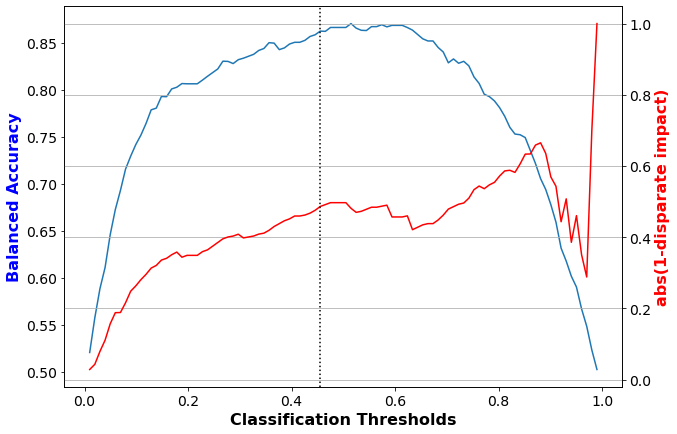

In [111]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_orig)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

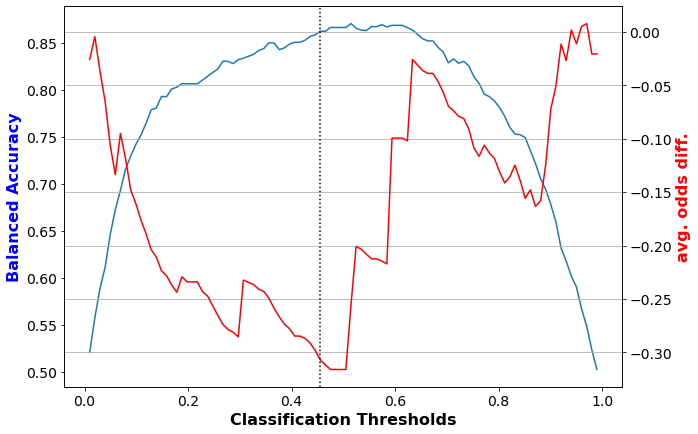

In [112]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_orig, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

*Note* <br>
average odds difference = 0.5((FPR_unpriv-FPR_priv)+(TPR_unpriv-TPR_priv)) must be close to zero for the classifier to be fair.
However, for a classifier trained with original training data, at the best classification rate, this is quite high. This implies unfairness.

In [113]:
# Step 4 Train classifier on transformed data
scale_transf = StandardScaler()
X_train = scale_transf.fit_transform(dataset_transf_train.features)
y_train = dataset_transf_train.labels.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train,
        sample_weight=dataset_transf_train.instance_weights)
y_train_pred = lmod.predict(X_train)

dataset_transf_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_transf.fit_transform(dataset_transf_test_pred.features)
y_test = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

display(Markdown("#### Predictions from transformed testing data"))
bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label
    
    metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_aft["Average odds difference"])
    disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])

#### Predictions from transformed testing data

Classification threshold used = 0.4555


 97%|█████████▋| 97/100 [00:00<00:00, 251.29it/s]

Balanced accuracy = 0.8746
Statistical parity difference = -0.2472
Disparate impact = 0.6404
Average odds difference = 0.0174
Equal opportunity difference = -0.0721
Theil index = 0.0920


invalid value encountered in double_scalars
100%|██████████| 100/100 [00:00<00:00, 224.09it/s]


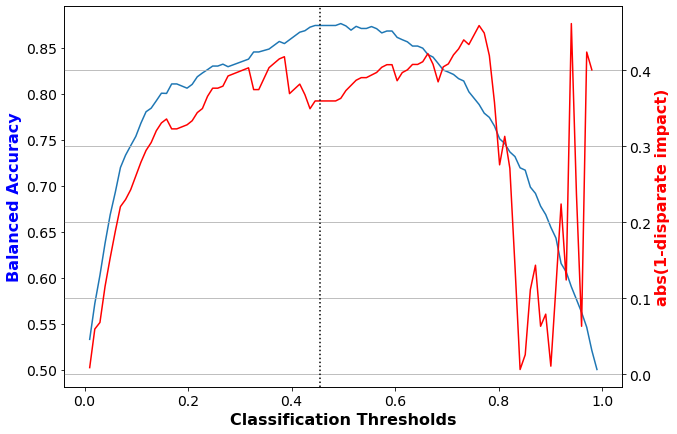

In [114]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

*Note* <br>
abs(1-disparate impact) must be small (close to 0) for classifier predictions to be fair.
For a classifier trained with reweighted training data, at the best classification rate, this is indeed the case. This implies fairness.

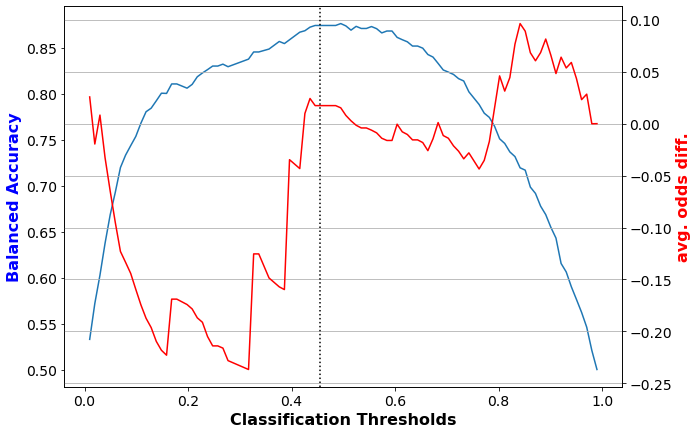

In [115]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_transf, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

*Note* <Br>
average odds difference = 0.5((FPR_unpriv-FPR_priv)+(TPR_unpriv-TPR_priv)) must be close to zero for the classifier to be fair.
For a classifier trained with reweighted training data, at the best classification rate, this is indeed the case. This implies fairness.